## Flowers-Recognition

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow 
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
train_path='../input/flowers-recognition/flowers'

from glob import glob
folders = glob(train_path + '/*') # useful for getting number of classes

folders

['../input/flowers-recognition/flowers/dandelion',
 '../input/flowers-recognition/flowers/daisy',
 '../input/flowers-recognition/flowers/sunflower',
 '../input/flowers-recognition/flowers/tulip',
 '../input/flowers-recognition/flowers/rose']

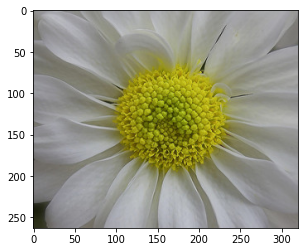

In [3]:
from matplotlib.pyplot import imshow, imread
image = imread("../input/flowers-recognition/flowers/daisy/100080576_f52e8ee070_n.jpg")
plt.imshow(image)

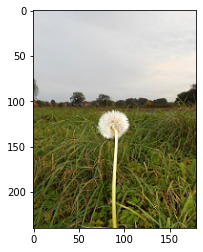

In [4]:
image = imread("../input/flowers-recognition/flowers/dandelion/10294487385_92a0676c7d_m.jpg")
plt.imshow(image)

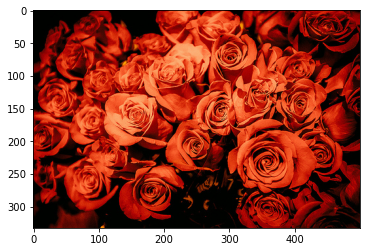

In [5]:
image=imread("../input/flowers-recognition/flowers/rose/10503217854_e66a804309.jpg")
plt.imshow(image)

In [6]:
image.size, image.shape

(499500, (333, 500, 3))

### AlexNet

In [7]:
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (227, 227),
                                                 batch_size = 256,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(train_path,
                                            target_size = (227, 227),
                                            batch_size = 256,
                                            class_mode = 'categorical')

Found 4317 images belonging to 5 classes.
Found 4317 images belonging to 5 classes.


In [8]:
train_sample=4317//256


test_sample=3317//256 #test_sample//batch size ie 4317//256 

train_sample, test_sample

(16, 12)

In [9]:
label_train = (training_set.class_indices)
label_train

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

In [10]:
label_test = (test_set.class_indices)
label_test

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

#### AlexNet architecture.
    
 <img src="https://anhreynolds.com/img/alexnet.png">
    
Input to this model have the dimensions 227x227x3 

In [11]:
model = Sequential(name='AlexNet')
# 1st Convolutional Layer
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), input_shape=(227,227,3), activation= 'relu',kernel_initializer= 'he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2)))

# 2nd Convolutional Layer
model.add(Conv2D(256, kernel_size=(5,5), strides= (1,1), activation= 'relu',padding= 'same', kernel_initializer= 'he_normal'))
model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2))) 

# 3rd Convolutional Layer
model.add(Conv2D(384, kernel_size=(3,3), strides= (1,1), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'))

# 4th Convolutional Layer
model.add(Conv2D(384, kernel_size=(3,3), strides= (1,1), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'))
# 5th Convolutional Layer

model.add(Conv2D(256, kernel_size=(3,3), strides= (1,1), padding= 'same', activation= 'relu', kernel_initializer= 'he_normal'))

model.add(MaxPooling2D(pool_size=(3,3), strides= (2,2)))

model.add(Flatten())
model.add(Dense(4096, activation= 'relu'))
model.add(Dense(4096, activation= 'relu'))
model.add(Dense(len(folders), activation= 'softmax'))

model.compile(optimizer= 'adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])


2022-03-24 16:46:51.525204: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
model.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       8849

#### Visualizing convolutional filter outputs in deep learning model

In [13]:
#Understand the filters in the model 
#Let us pick the first hidden layer as the layer of interest.
layer = model.layers
filters, biases = model.layers[2].get_weights()
print(layer[2].name, filters.shape)

conv2d_1 (5, 5, 96, 256)


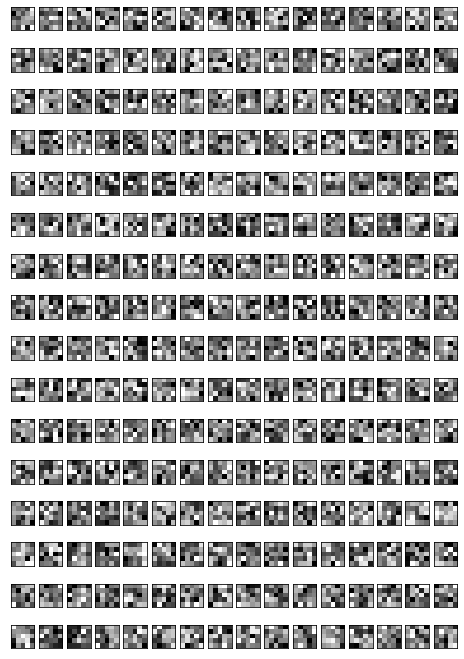

In [14]:
# plot filters

fig1=plt.figure(figsize=(8, 12))
columns = 16
rows = 16
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
plt.show()   

In [15]:
#Define a new truncated model to only include the conv layers of interest
conv_layer_index = [0,2]  
outputs = [model.layers[i].output for i in conv_layer_index]
model_short = Model(inputs=model.inputs, outputs=outputs)
print(model_short.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_input (InputLayer)    [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
Total params: 649,600
Trainable params: 649,600
Non-trainable params: 0
_________________________________________________________________
None


2022-03-24 16:47:02.825845: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


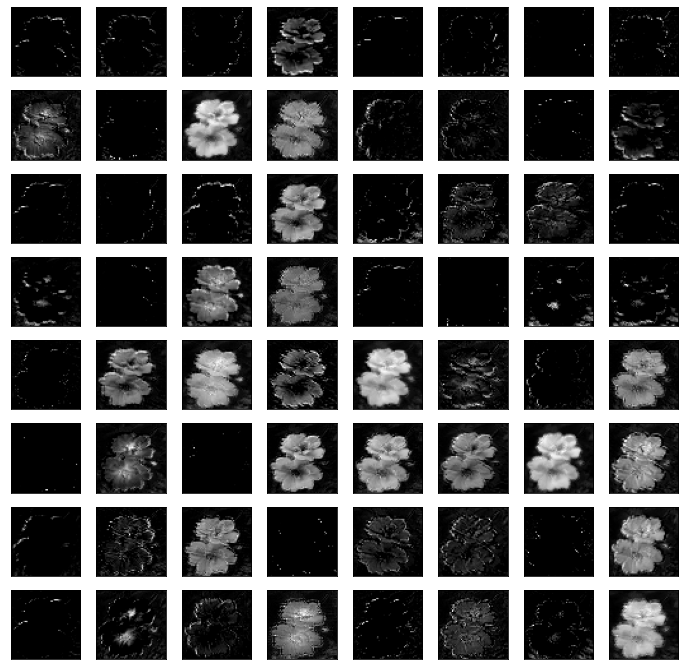

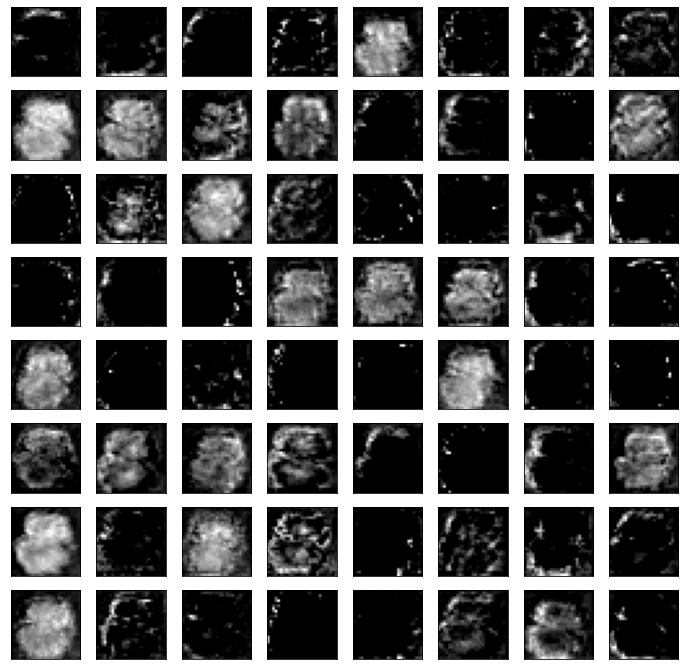

In [16]:
from keras.preprocessing.image import load_img, img_to_array
img = load_img('../input/flowers-recognition/flowers/rose/10090824183_d02c613f10_m.jpg', target_size=(227, 227)) 

# convert the image to an array
img = img_to_array(img)
# expand dimensions to match the shape of model input
img = np.expand_dims(img, axis=0)

# Generate feature output by predicting on the input image
feature_output = model_short.predict(img)


columns = 8
rows = 8
for ftr in feature_output:
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, columns*rows +1):
        fig =plt.subplot(rows, columns, i)
        fig.set_xticks([])  #Turn off axis
        fig.set_yticks([])
        plt.imshow(ftr[0, :, :, i-1], cmap='gray')
        
    plt.show()

In [17]:
r = model.fit(training_set, validation_data=test_set, epochs=5, steps_per_epoch=16, validation_steps=12) 

Epoch 1/5
16/16 [==============================] - 321s 20s/step - loss: 22.9935 - accuracy: 0.2236 - val_loss: 1.5986 - val_accuracy: 0.2318
Epoch 2/5
16/16 [==============================] - 311s 19s/step - loss: 1.5783 - accuracy: 0.2674 - val_loss: 1.4871 - val_accuracy: 0.3001
Epoch 3/5
16/16 [==============================] - 314s 20s/step - loss: 1.6023 - accuracy: 0.2874 - val_loss: 1.5536 - val_accuracy: 0.2689
Epoch 4/5
16/16 [==============================] - 311s 20s/step - loss: 1.5791 - accuracy: 0.2893 - val_loss: 1.4756 - val_accuracy: 0.3597
Epoch 5/5
16/16 [==============================] - 311s 19s/step - loss: 1.4243 - accuracy: 0.3849 - val_loss: 1.2923 - val_accuracy: 0.4440


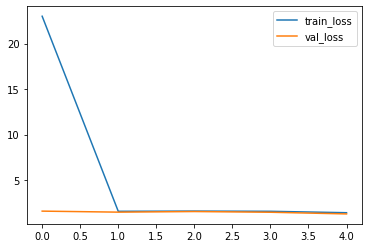

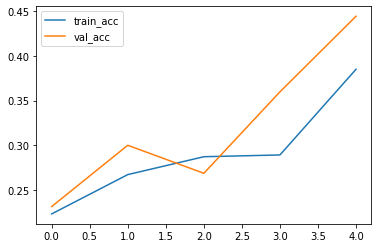

<Figure size 432x288 with 0 Axes>

In [18]:
# loss
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracy
plt.plot(r.history['accuracy'], label='train_acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

prob: 3
prediction_shape: (1, 5)
class_name: ['sunflower']


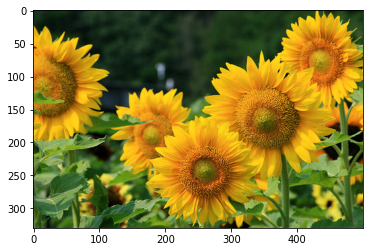

In [19]:
# train data prediction
import cv2
img = imread('../input/flowers-recognition/flowers/sunflower/1008566138_6927679c8a.jpg')
imshow(img)
img = cv2.resize(img,(227,227))
img = np.reshape(img,[1,227,227,3])
prediction = model.predict(img)
y_classes = prediction.argmax(axis=-1)
class_label=[i for i, v in label_train.items() if v==y_classes]
print("prob:", np.argmax(prediction))
print("prediction_shape:", prediction.shape)
print("class_name:",class_label)

prob: 4
prediction_shape: (1, 5)
class_name: ['tulip']


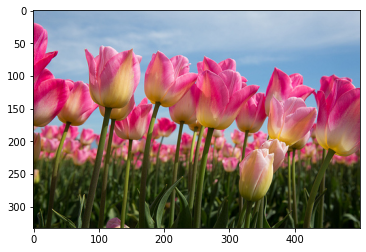

In [20]:
# train data prediction
img = imread('../input/flowers-recognition/flowers/tulip/10128546863_8de70c610d.jpg')
imshow(img)
img = cv2.resize(img,(227,227))
img = np.reshape(img,[1,227,227,3])
prediction = model.predict(img)
y_classes = prediction.argmax(axis=-1)
class_label=[i for i, v in label_train.items() if v==y_classes]
print("prob:", np.argmax(prediction))
print("prediction_shape:", prediction.shape)
print("class_name:",class_label)

### VGG16

#### VGG16 Architecture

<img src="https://iq.opengenus.org/content/images/2019/01/vgg_layers.png">


 Input to this model have the dimensions (224, 224, 3)
 
 VGG16_paper: <a href="https://arxiv.org/pdf/1409.1556v6.pdf"> VERY DEEP CONVOLUTIONAL NETWORKS FOR LARGE-SCALE IMAGE RECOGNITION </a>


In [21]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(train_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 4317 images belonging to 5 classes.
Found 4317 images belonging to 5 classes.


In [22]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions 

input_shapes=[224,224,3]
vgg = VGG16(input_shape = input_shapes, weights = 'imagenet', include_top = False)

for layer in vgg.layers: # don't train existing weights
    layer.trainable = False

# Classification block
x = Flatten(name='flatten')(vgg.output)  # get the VGG block 5 output (vgg.output)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(len(folders), activation='softmax', name='predictions')(x)

# Create model.
model = Model(inputs = vgg.input, outputs = x, name='vgg16')

#model structure
model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = 'accuracy')


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [23]:
# fit the model
r = model.fit(training_set, validation_data=test_set, epochs=2, steps_per_epoch=16, validation_steps=12)

Epoch 1/2
16/16 [==============================] - 234s 15s/step - loss: 13.0958 - accuracy: 0.2617 - val_loss: 1.3220 - val_accuracy: 0.4766
Epoch 2/2
16/16 [==============================] - 234s 15s/step - loss: 1.0473 - accuracy: 0.6035 - val_loss: 0.8889 - val_accuracy: 0.6797


prob: 2
prediction_shape: (1, 5)
class_name: ['rose']


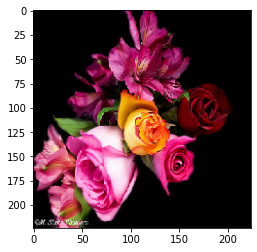

In [24]:
img_path = '../input/flowers-recognition/flowers/rose/11233672494_d8bf0a3dbf_n.jpg'
img = tensorflow.keras.preprocessing.image.load_img(img_path, target_size=(224, 224)) #Resize the image
imshow(img)
img_array = tensorflow.keras.preprocessing.image.img_to_array(img) #output Numpy-array
img_batch = np.expand_dims(img_array, axis=0) # deep learning models expect a batch of images as input
img_preprocessed = tensorflow.keras.applications.vgg16.preprocess_input(img_batch)# the image pixel values are range from 0 to 255. normalize
prediction = model.predict(img_preprocessed)
y_classes = np.argmax(prediction)
class_label=[i for i, v in label_train.items() if v==y_classes]
print("prob:", np.argmax(prediction))
print("prediction_shape:", prediction.shape)
print("class_name:",class_label)

                                                                                                                   Thank You